The aim of this notebook is to investigate SimSiam collapse.

In [1]:
import sys 
sys.path.append('..')

In [8]:
import matplotlib.pyplot as plt
import torch

from types import SimpleNamespace
from monai.data import DataLoader, Dataset

from src.loaders import get_ssl_data
from src.transforms import get_ssl_transforms_2d
from src.models import Backbone, SimSiam

In [9]:
args = SimpleNamespace(**{
    'min_iou': 0.0, 'max_iou': 0.0, 'data_dir': '../data/ssl_preprocessed_2d/',
    'batch_size': 4, 'embedding_size': 48, 'chkpt_path': '../chkpts/test_simsiam_24h_ares_iou_0.pt',
    'spatial_dims': 2, 'low_resource_mode': False, 'drop_path_rate': 0.1,
    'use_gradient_checkpointing': False
})

In [10]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

transforms = get_ssl_transforms_2d(args)
ds = Dataset(
    data=get_ssl_data(args.data_dir), 
    transform=transforms
)

data_loader = DataLoader(
    ds, 
    batch_size=args.batch_size,
    num_workers=2,
    shuffle=True,
    pin_memory=torch.cuda.is_available()
)

The following transforms pipeline will be used: [<monai.transforms.io.dictionary.LoadImaged object at 0x7fb5a9feba90>, <monai.transforms.intensity.dictionary.ScaleIntensityRanged object at 0x7fb5a9feb790>, <monai.transforms.utility.dictionary.EnsureChannelFirstd object at 0x7fb5a9fea530>, <monai.transforms.utility.dictionary.EnsureTyped object at 0x7fb5a9fe9c90>, <src.transforms.IoUCropd object at 0x7fb5a9feb4f0>, <monai.transforms.utility.dictionary.EnsureTyped object at 0x7fb5a9f874c0>].


/home/ditto/envs/sslct/lib/python3.10/site-packages/monai/utils/deprecate_utils.py:321: FutureWarning: monai.transforms.io.dictionary LoadImaged.__init__:image_only: Current default value of argument `image_only=False` has been deprecated since version 1.1. It will be changed to `image_only=True` in version 1.3.
  warn_deprecated(argname, msg, warning_category)


In [5]:
model = SimSiam(
    backbone=Backbone(args),
    backbone_out_dim=args.embedding_size*2**4
).to(device)

In [6]:
state_dict = torch.load(args.chkpt_path, map_location=torch.device('cpu'))
model.load_state_dict(state_dict)

<All keys matched successfully>

The loaded checkpoint corresponds to a model with very high collapse value 
(low std for prediction head output) and relatively high loss (about -0.5).

This means that at one point prediction head always returns similar representations
whereas it's different than projection head representations.

I should therefore be able to see:

* similar projection head representations for any input;
* low std for projection head across batch;
* noticeable differences when comparing p1 with z2 and z1 with p2.

Batch 0 loaded...
Visualizing first pair from the batch...


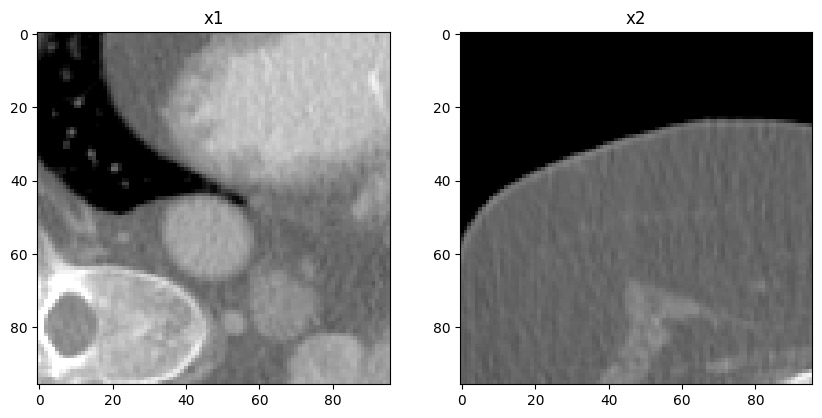

Printing first 10 dims for projection head...
z1: tensor([ 0.0107, -0.0202, -0.0179,  0.0226,  0.0089, -0.0231, -0.0222,  0.0102,
        -0.0092, -0.0288]), std for whole batch: 0.025257209315896034
z2: tensor([ 0.0274, -0.0104, -0.0176,  0.0319,  0.0118, -0.0238, -0.0317, -0.0303,
        -0.0310, -0.0327]), std for whole batch: 0.025121120736002922
Printing first 10 dims for prediction head...
p1: tensor([-0.0263,  0.0289, -0.0136, -0.0220, -0.0241,  0.0270,  0.0178,  0.0044,
         0.0228,  0.0225], grad_fn=<SliceBackward0>), std for whole batch: 0.0031065603252500296
p2: tensor([-0.0268,  0.0249, -0.0092, -0.0249, -0.0276,  0.0248,  0.0190,  0.0019,
         0.0246,  0.0255], grad_fn=<SliceBackward0>), std for whole batch: 0.0006011862424202263


In [19]:
for batch_idx, data_dict in enumerate(data_loader):
    print(f'Batch {batch_idx} loaded...')

    x1, x2 = data_dict['img1'].to(device), data_dict['img2'].to(device)
    z1, p1 = model(x1)
    z2, p2 = model(x2)

    # Visualize input
    print('Visualizing first pair from the batch...')
    _, axs = plt.subplots(1, 2, figsize=(10, 10))

    axs[0].imshow(x1[0, 0].cpu(), cmap='gray', vmin=0, vmax=1)
    axs[0].set_title('x1')

    axs[1].imshow(x2[0, 0].cpu(), cmap='gray', vmin=0, vmax=1)
    axs[1].set_title('x2')

    plt.show()

    # Print zs
    z1 = torch.nn.functional.normalize(z1, dim=1)
    z2 = torch.nn.functional.normalize(z2, dim=1)

    print('Printing first 10 dims for projection head...')
    print(f'z1: {z1[0, :10]}, std for whole batch: {torch.std(z1, dim=0).mean().item()}')
    print(f'z2: {z2[0, :10]}, std for whole batch: {torch.std(z2, dim=0).mean().item()}')

    # Print ps
    p1 = torch.nn.functional.normalize(p1, dim=1)
    p2 = torch.nn.functional.normalize(p2, dim=1)

    print('Printing first 10 dims for prediction head...')
    print(f'p1: {p1[0, :10]}, std for whole batch: {torch.std(p1, dim=0).mean().item()}')
    print(f'p2: {p2[0, :10]}, std for whole batch: {torch.std(p2, dim=0).mean().item()}')

    break

[x] similar projection head representations for any input

[x] low std for projection head across batch

[x] noticeable differences when comparing p1 with z2 and z1 with p2

In [ ]:
# TODO: more precise analysis (PCA, stats etc.) if needed